In [1]:
%load_ext autoreload
%autoreload 2
import sys
import copy
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import abstract_gradient_training as agt
from abstract_gradient_training.bounds import interval_bound_propagation as ibp
from abstract_gradient_training import AGTConfig
sys.path.append("../")
from models.fully_connected import FullyConnected
from datasets.blobs import get_dataloaders

# Preliminaries

Set the plotting style, abstract gradient training configuration, prepare the blobs dataset and initialise the model.

In [22]:
# Set plotting and functional parameters
SEED = 1234
HIDDEN_DIM = 128
HIDDEN_LAY = 1
BATCHSIZE = 2000
torch.manual_seed(SEED)

# Set the nominal configuration for the certified training
NOMINAL_CONFIG = AGTConfig(
    learning_rate=2.0,
    l2_reg=0.02,
    n_epochs=2,
    device="cuda:1",
    forward_bound="interval,crown",
    backward_bound="interval",
    loss="cross_entropy",
    lr_decay=0.6,
    lr_min=1e-3,
    early_stopping=False,
    log_level="WARNING",
)

In [23]:
DL_TRAIN_CLOSE, DL_TEST_CLOSE = get_dataloaders(BATCHSIZE, 1, 0.75, SEED)
DL_TRAIN_FAR, DL_TEST_FAR = get_dataloaders(BATCHSIZE, 1.25, 0.35, SEED)

# Initialise the neural network model
MODEL = FullyConnected(in_dim=6, out_dim=2, hidden_dim=HIDDEN_DIM, hidden_lay=HIDDEN_LAY)

# Sweep and plotting functions

Define functions for sweeping over a specific AGT config parameter and plotting the results as a contour plot.

In [71]:
def run_sweep(sweep_variable, sweep_values, config, dl, dl_test, type):
    """
    For the config parameter with name sweep_variable, run certified training for sweep_variable set to each value
    in sweep_values.
    """
    config = copy.deepcopy(config)
    results = []
    for v in sweep_values:
        config.__setattr__(sweep_variable, v)
        torch.manual_seed(SEED)
        if type == "unlearning":
            param_l, param_n, param_u = agt.unlearning_certified_training(MODEL, config, dl, dl_test)
        elif type == "privacy":
            param_l, param_n, param_u = agt.privacy_certified_training(MODEL, config, dl, dl_test)
        results.append((v, param_l, param_n, param_u))

    for _, _, p_n, _ in results:
        assert all([torch.allclose(p_n[i], param_n[i]) for i in range(len(param_n))])
    return results


def plot_sweep(results, dl_test, ax, cm, plot_cbar=False, location="right", cbar_label=""):
    """
    Given the parameter bounds in the results list returned from run_sweep, compute the worst-case predictions for a
    grid of points covering the half-moon dataset and plot the results as a contour plot.
    """

    # get the whole test dataset
    x_test, y_test = dl_test.dataset.tensors

    # define a grid of points to evaluate the model at
    x = torch.linspace(-GRIDLIM, GRIDLIM, GRIDSIZE)
    y = torch.linspace(-GRIDLIM, GRIDLIM, GRIDSIZE)
    X, Y = torch.meshgrid(x, y)

    # add polynomial features
    in_data = torch.stack(
        (
            X.flatten(),
            Y.flatten(),
            X.flatten() ** 2,
            Y.flatten() ** 2,
            X.flatten() ** 3,
            Y.flatten() ** 3,
        ),
        dim=1,
    )

    in_data = in_data.unsqueeze(-1).to(NOMINAL_CONFIG.device).float()

    # compute the nominal model predictions
    param_n = results[0][2]
    *_, logits = agt.nominal_pass.nominal_forward_pass(in_data, param_n)
    logits = logits.argmax(dim=1).reshape(GRIDSIZE, GRIDSIZE)
    worst_case_0 = torch.zeros_like(logits)
    worst_case_1 = torch.zeros_like(logits)
    logits = logits.detach().cpu().numpy()
    ax.contour(X, Y, logits, cmap=CM_NOMINAL, alpha=1.0, levels=[0.5])

    # for each result in the sweep, compute the worst-case predictions for the entire grid
    for _, param_l, param_n, param_u in results:
        (*_, logits_l), (*_, logits_u) = ibp.bound_forward_pass(param_l, param_u, in_data, in_data)
        worst_case_0 += torch.hstack([logits_l[:, 0], logits_u[:, 1]]).argmax(dim=1).reshape(GRIDSIZE, GRIDSIZE)
        worst_case_1 += 1 - torch.hstack([logits_u[:, 0], logits_l[:, 1]]).argmax(dim=1).reshape(GRIDSIZE, GRIDSIZE)

    # plot the worst-case predictions
    worst_case = torch.min(worst_case_0, worst_case_1).detach().cpu().numpy()
    boundaries = list(range(-1, len(results) + 1, 1))
    # norm = mpl.colors.Normalize(vmin=worst_case.min(), vmax=worst_case.max())
    cont = ax.contourf(X, Y, worst_case, cmap=cm, alpha=1.0, levels=boundaries)
    tick_positions = [(boundaries[i] + boundaries[i + 1]) / 2 for i in range(len(boundaries) - 1)]

    # # define custom colorbar
    # if plot_cbar:
    #     cbar = plt.colorbar(
    #         cont, ticks=tick_positions[1:], location=location, boundaries=boundaries[1:], ax=ax, label=cbar_label
    #     )
    #     cbar.ax.set_ylim(0, len(results))
    #     cbar.set_ticklabels([f"${r[0]}$" for r in reversed(results)])  # Set custom tick labels
    #     cbar.ax.tick_params(length=0) 
    # plot the test dataset
    ax.scatter(x_test[:, 0], x_test[:, 1], s=MARKERSIZE, c=y_test, edgecolors="#c0d1c9", linewidths=0.4, cmap=CM_BRIGHT)
    
    return cont, tick_positions, boundaries

# Run all sweeps

Define the sweep configurations and run all sweeps to get parameter bounds.

In [26]:
config = copy.deepcopy(NOMINAL_CONFIG)
config.clip_gamma = 0.08

In [29]:
# Run sweeps for close and far blobs datasets, for privacy and unlearning
KS_PRIVACY = [25, 50, 75, 100]
KS_UNLEARNING = [50, 100, 150, 200]
results_close_privacy = run_sweep("k_private", KS_PRIVACY, config, DL_TRAIN_CLOSE, DL_TEST_CLOSE, "privacy")
results_close_unlearning = run_sweep("k_unlearn", KS_UNLEARNING, config, DL_TRAIN_CLOSE, DL_TEST_CLOSE, "unlearning")
results_far_privacy = run_sweep("k_private", KS_PRIVACY, config, DL_TRAIN_FAR, DL_TEST_FAR, "privacy")
results_far_unlearning = run_sweep("k_unlearn", KS_UNLEARNING, config, DL_TRAIN_FAR, DL_TEST_FAR, "unlearning")

# Plot all results

Plot the results of all sweeps, showing the "certified" region for each setting of k.

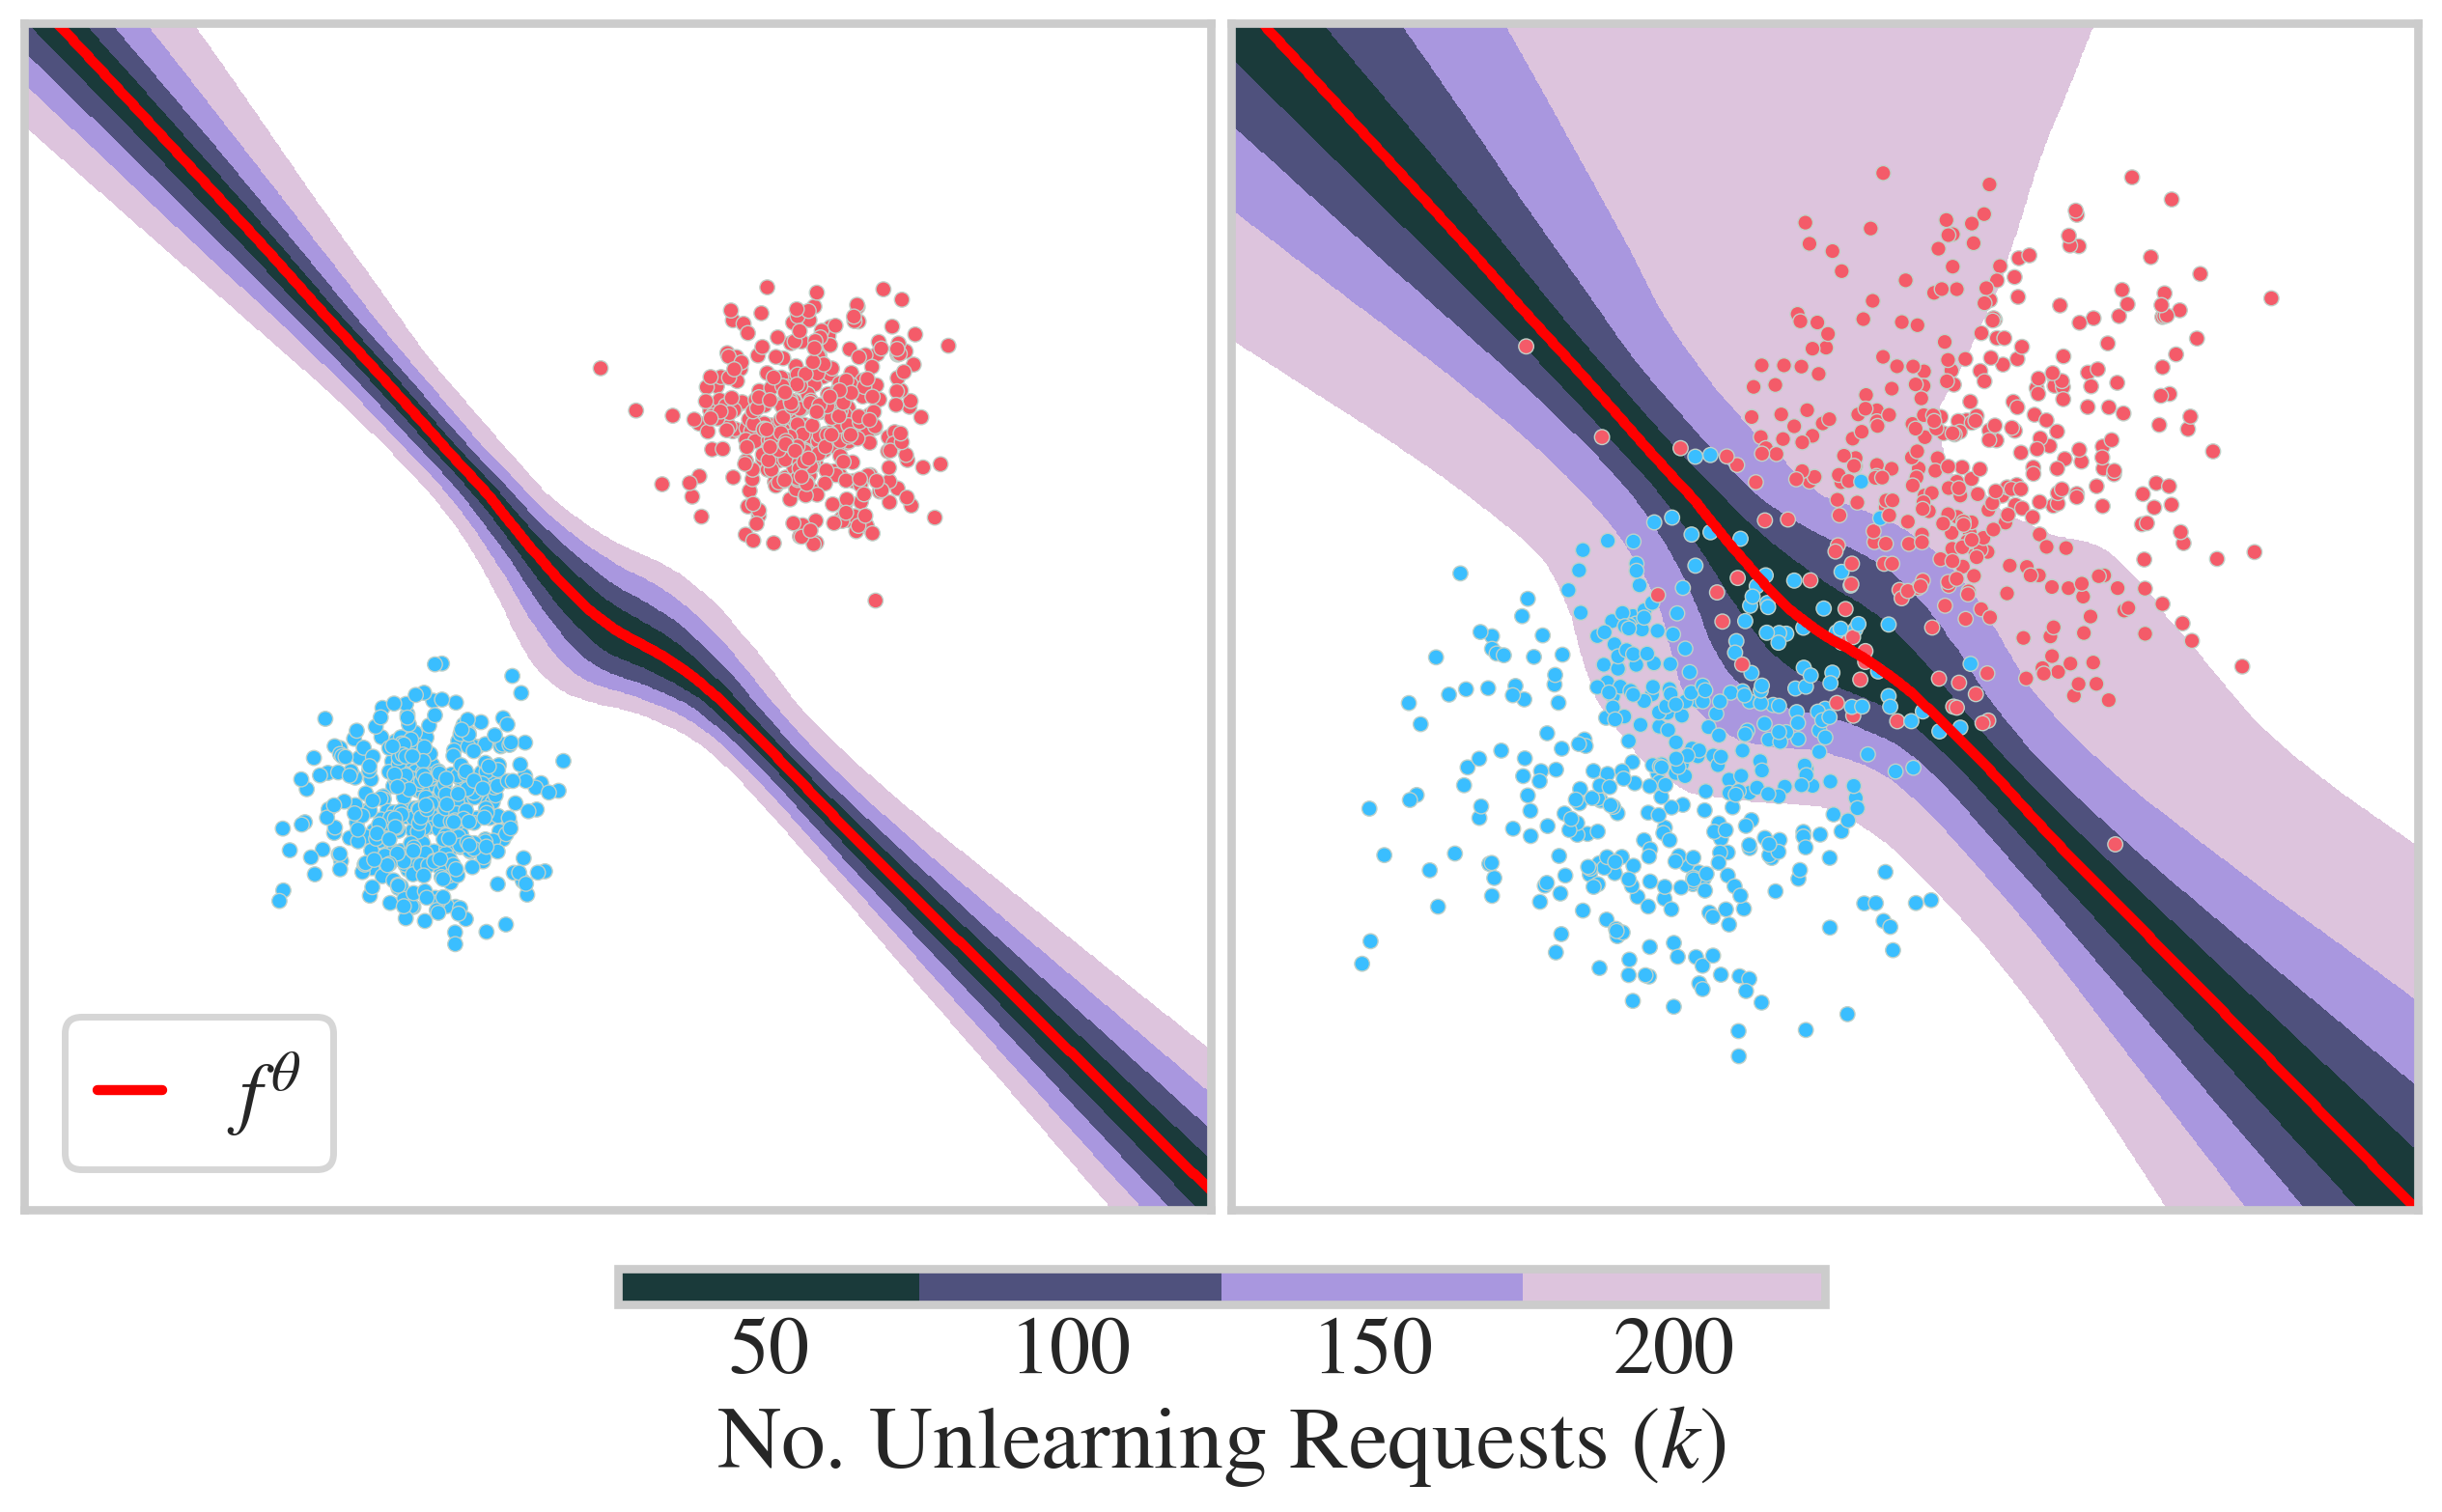

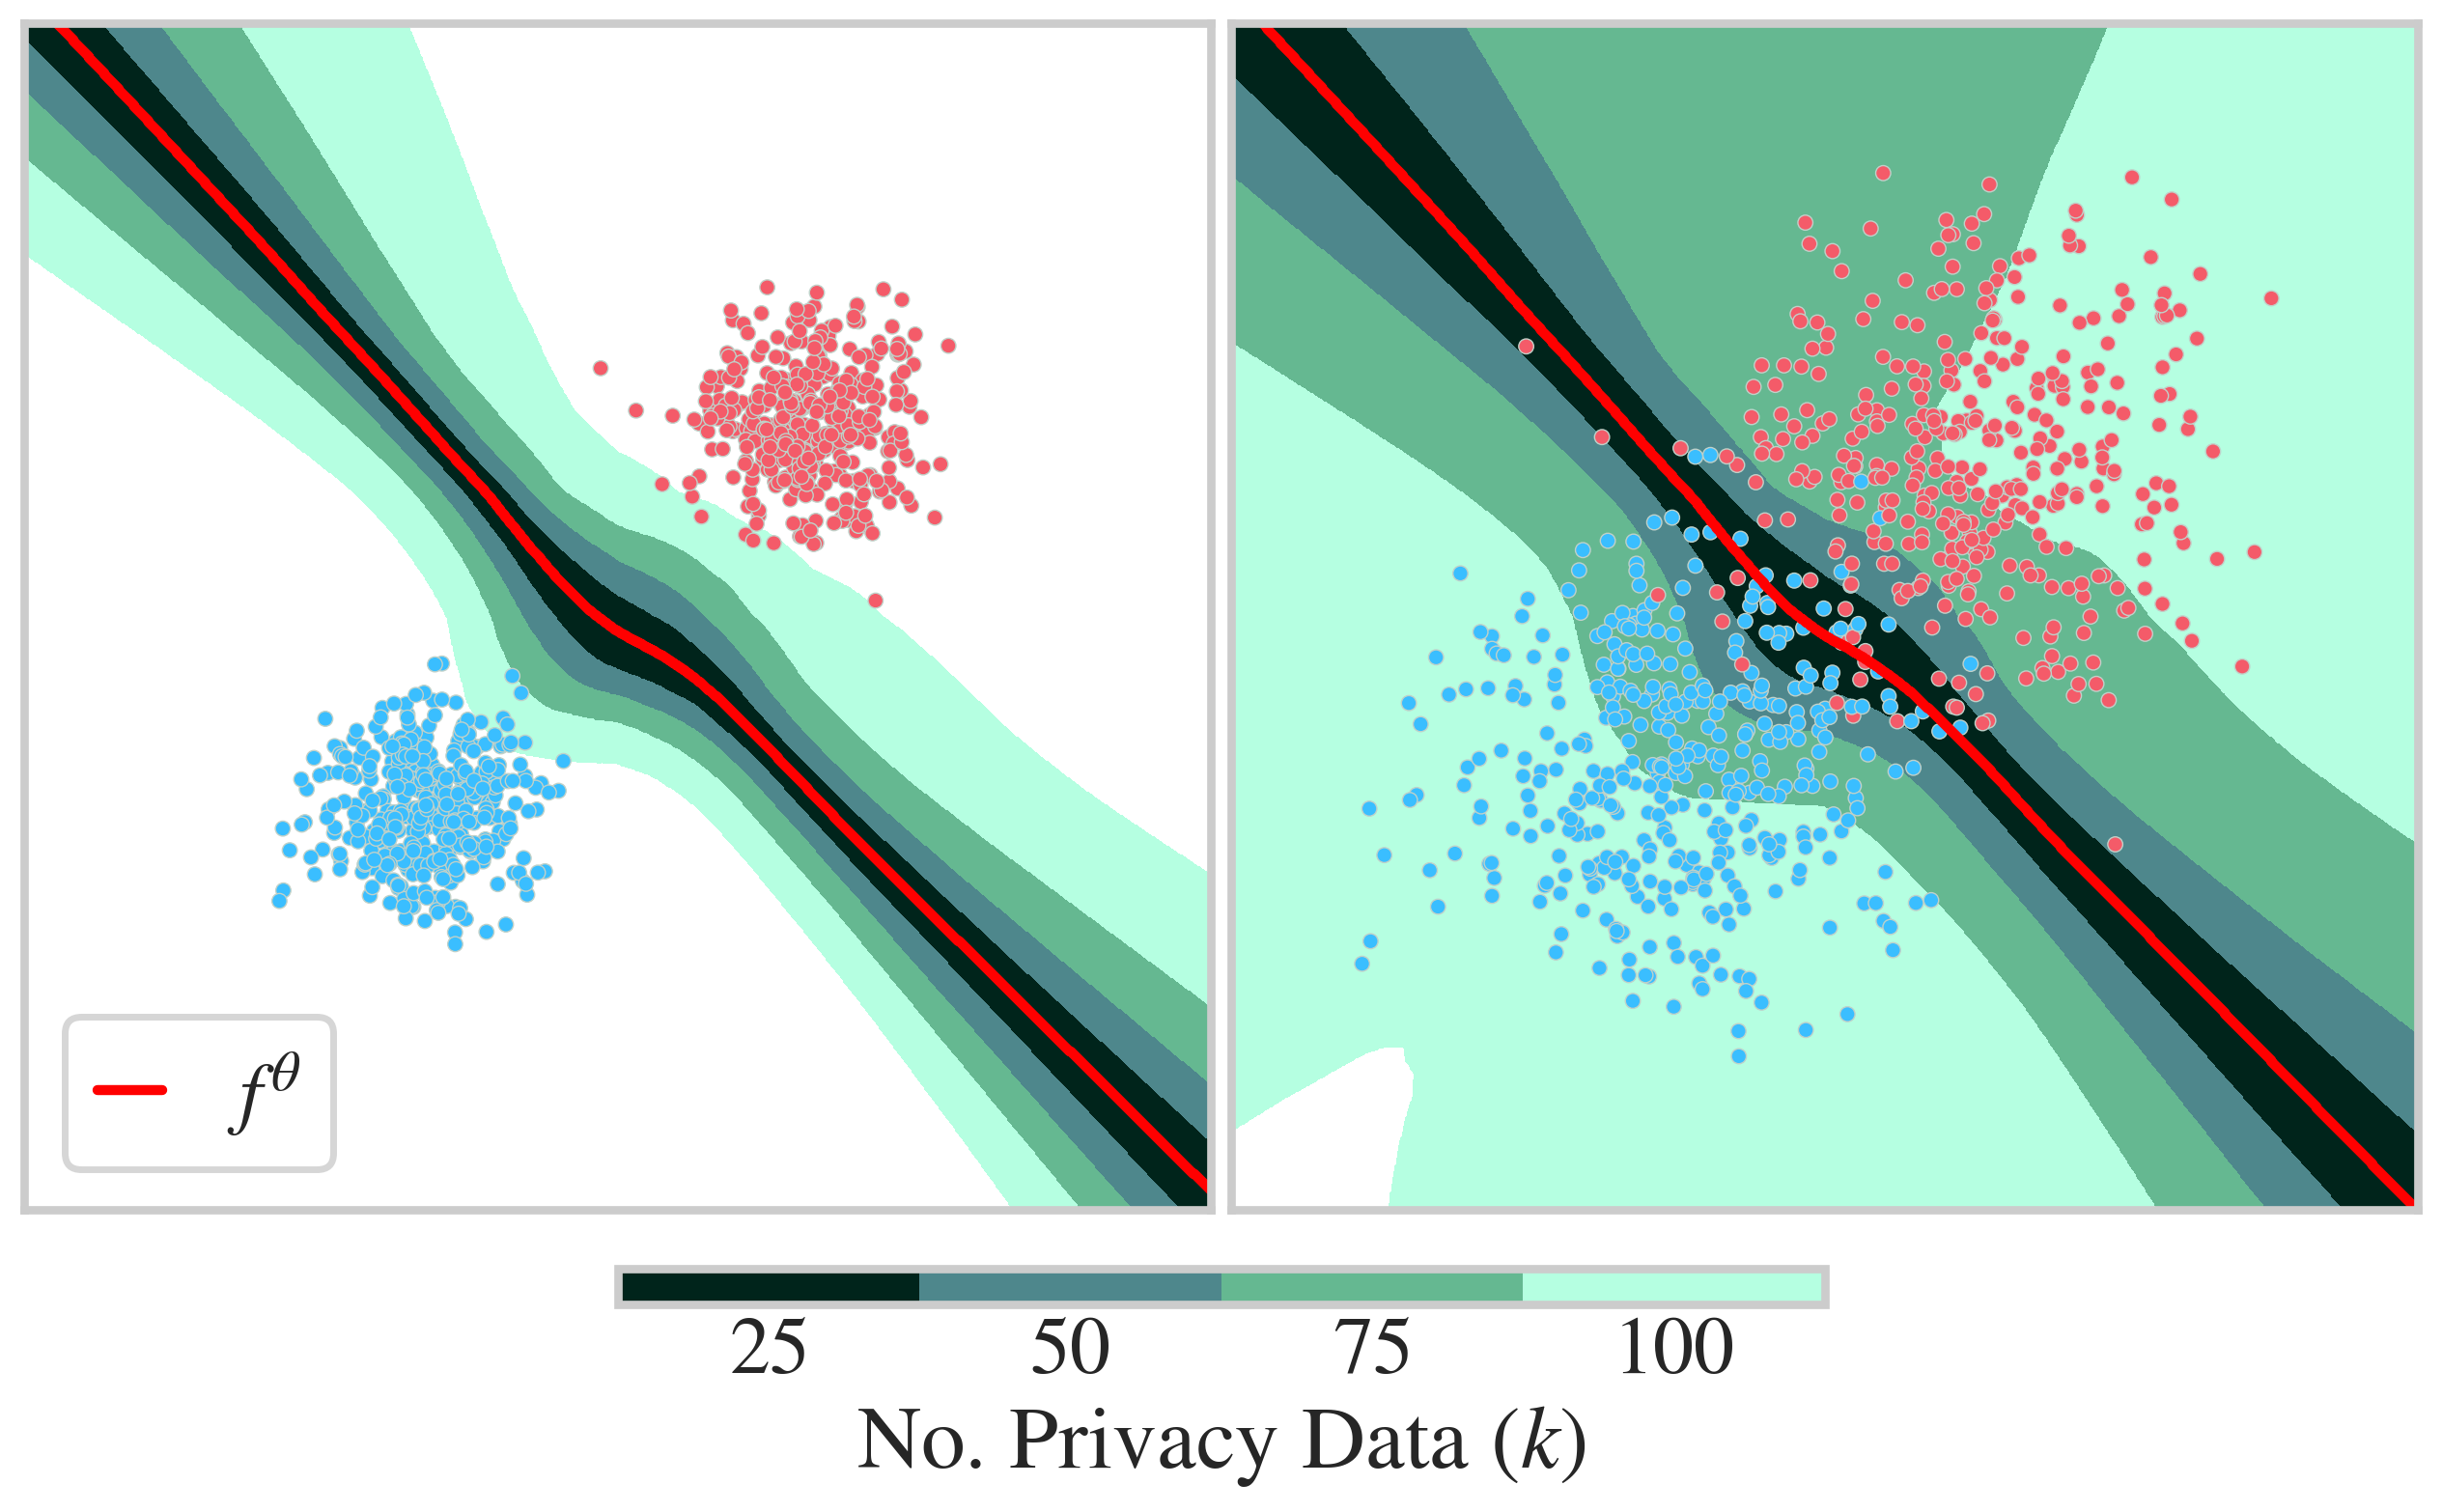

In [79]:
sns.set_theme(context="poster", style="whitegrid", font_scale=1.1)
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"

CM_BRIGHT = mpl.colors.ListedColormap(["#F45B69", "#3ABEFF"])
CM_NOMINAL = mpl.colors.ListedColormap(["#FF0000"])
CM_PRIVACY = mpl.colors.ListedColormap(["#ffffff", "#B5FFE1", "#93E5AB", "#65B891", "#4E878C", "#00241B"])
CM_UNLEARNING = mpl.colors.ListedColormap(["#ffffff", "#DDC4DD", "#DCCFEC", "#A997DF", "#4F517D", "#1A3A3A"])
MARKERSIZE = 20
GRIDSIZE = 1000
GRIDLIM = 3.8

fig, axs = plt.subplots(
    1,
    2,
    figsize=(10, 5),
    dpi=250,
    sharey=True,
    layout="constrained",
    gridspec_kw={"hspace": 0.01, "wspace": 0.01},
)

for ax in axs:
    ax.set_aspect("equal")
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(-GRIDLIM, GRIDLIM)
    ax.set_ylim(-GRIDLIM, GRIDLIM)

plot_sweep(results_far_unlearning, DL_TEST_FAR, axs[0], CM_UNLEARNING, False)
cont, tick_pos, bounds = plot_sweep(
    results_close_unlearning, DL_TEST_CLOSE, axs[1], CM_UNLEARNING, True, cbar_label="No. Unlearning Requests ($k$)"
)
red_line = mpl.lines.Line2D([], [], color="red", label=r"$f^{\theta}$")
axs[0].legend(handles=[red_line], loc="lower left", handlelength=0.8)

cbar_ax = fig.add_axes([0.25, -0.07, 0.5, 0.03])  # [left, bottom, width, height]
norm = mpl.colors.Normalize(vmin=0, vmax=4)
cbar = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=mpl.colors.ListedColormap(["#DDC4DD", "#A997DF", "#4F517D", "#1A3A3A"][::-1]), norm=norm),
    cax=cbar_ax,
    orientation="horizontal",
    ticks=tick_pos[1:],
    boundaries=bounds[1:],
    label="No. Unlearning Requests ($k$)",
)
cbar.set_ticklabels([f"${r[0]}$" for r in results_close_unlearning])  # Set custom tick labels
cbar.ax.tick_params(length=0)
cbar.ax.set_xlim(0, len(results_close_unlearning))

plt.savefig(".figures/blobs_unlearning.pdf", bbox_inches="tight", dpi=350)


fig, axs = plt.subplots(
    1,
    2,
    figsize=(10, 5),
    dpi=250,
    sharey=True,
    layout="constrained",
    gridspec_kw={"hspace": 0.01, "wspace": 0.01},
)

for ax in axs:
    ax.set_aspect("equal")
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(-GRIDLIM, GRIDLIM)
    ax.set_ylim(-GRIDLIM, GRIDLIM)

plot_sweep(results_far_privacy, DL_TEST_FAR, axs[0], CM_PRIVACY, False)
cont, tick_pos, bounds = plot_sweep(
    results_close_privacy,
    DL_TEST_CLOSE,
    axs[1],
    CM_PRIVACY,
    True,
    location="bottom",
    cbar_label="No. Privacy Data ($k$)",
)

cbar_ax = fig.add_axes([0.25, -0.07, 0.5, 0.03])  # [left, bottom, width, height]
norm = mpl.colors.Normalize(vmin=0, vmax=4)

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=mpl.colors.ListedColormap(["#00241B", "#4E878C", "#65B891", "#B5FFE1"]), norm=norm),
    cax=cbar_ax,
    orientation="horizontal",
    ticks=[0.5, 1.5, 2.5, 3.5],
    boundaries=[0, 1, 2, 3, 4],
    label="No. Privacy Data ($k$)",
)
cbar.set_ticklabels([f"${r[0]}$" for r in results_close_privacy])  # Set custom tick labels
cbar.ax.tick_params(length=0)
# cbar.ax.set_xlim(0, len(results_close_privacy))

red_line = mpl.lines.Line2D([], [], color="red", label=r"$f^{\theta}$")
axs[0].legend(handles=[red_line], loc="lower left", handlelength=0.8)

plt.savefig(".figures/blobs_privacy.pdf", bbox_inches="tight", dpi=350)